# Pneumonia Detection

Pneumonia is a lung infection that can affect the lungs in various ways, compromising gas exchange and leading to symptoms such as cough, fever, shortness of breath, and chest pain. It can be caused by bacteria, viruses, fungi, or, in some cases, by less common organisms. The severity of pneumonia varies depending on the infectious agent involved, the patient’s age, and their overall health. In severe cases, especially in the elderly and immunocompromised individuals, pneumonia can lead to serious complications and even death.

Early and accurate diagnosis is crucial for effective treatment of pneumonia. Traditionally, clinical and radiological exams, such as chest X-ray images, have been essential tools in this process. The analysis of these images allows the identification of typical signs of pneumonia, such as pulmonary opacities and changes in ventilation patterns, which help distinguish between different types of pneumonia and assess the severity of the infection.

A pneumonia detection system in X-ray images using artificial intelligence and machine learning can be extremely useful in medicine, as it offers the possibility of speeding up diagnosis, improving accuracy, and reducing human error. These automated systems can analyze large volumes of images quickly and effectively, providing additional support to doctors, especially in areas with few specialists or in situations of high demand, such as during respiratory disease outbreaks. Furthermore, early detection through these technologies can facilitate the choice of appropriate treatment, reducing the risk of complications and improving patient outcomes.

## Objective:
Pneumonia detection using Convolutional Neural Networks trained on chest X-ray image data.

* **What is the problem description?** - This is a binary classification problem. It involves determining whether a lung is healthy or has pneumonia.
* **Do you have any assumptions or hypotheses about the problem? What are they?** - There are no assumptions or hypotheses for the problem, as it is a well-defined problem with a clear objective.
* **What restrictions or conditions were imposed to select the data?** - The data was obtained from [Kaggle](https://www.kaggle.com/), and minimal preprocessing was applied. The data was already consistent, so only data augmentation was necessary.
* **Describe your dataset (attributes, images, annotations, etc.).** - The dataset consists of chest X-ray images from different individuals, some with healthy lungs and others with pneumonia.

First, let's mount the drive to store the output data generated by the model training. More specifically, we will save the weights and biases from the training of our model so that we can later use them for classification.

This could also be saved locally.

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Diretório onde você deseja salvar o modelo
directory = '/content/drive/My Drive/colab_models'

# Criar o diretório, se não existir
os.makedirs(directory, exist_ok=True)

# Diretório para salvar os arquivos no Google Drive
weights_filepath = os.path.join(directory, 'best_model_2_todate.weights.h5')

Mounted at /content/drive


Then, let's download the images data using kagglehub api.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:18<00:00, 31.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


Here i dowload some librarys that colab doensn't have or needed to be updated.

In [3]:
!pip install tensorflow
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


Importing the libraries that we need for the task and setting up the development environment.

We set the seeds to 111 for reproducibility.

In [28]:
import glob
import h5py
import shutil
import imgaug as aug
import tensorflow as tf
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
import seaborn as sns
from sklearn.metrics import confusion_matrix
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,
    SeparableConv2D, GlobalMaxPooling2D, BatchNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast
from tensorflow.keras.utils import to_categorical

# Configurar a semente para operações baseadas em hash no Python
os.environ['PYTHONHASHSEED'] = '0'

# Configurar a semente para o NumPy
np.random.seed(111)

# Configurar a semente para operações no TensorFlow
tf.random.set_seed(111)

# Configurações para limitar o paralelismo no TensorFlow
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Data Preparation:
Perform data preparation operations.

- **Split the dataset into training and testing (and validation, if applicable)**  
  The dataset is already divided into training, validation, and testing data.

- **Does it make sense to use a cross-validation method?**  
  Cross-validation could be used, but the training time would be significantly longer. The model was trained for 20 epochs, and the process took over two days. Additionally, since the dataset was already split into testing/validation, I chose not to perform cross-validation.

- **Check which data transformation operations (such as normalization, standardization, and transforming images into tensors) are most appropriate for your problem and save different versions of your dataset for later model evaluation.**  
  The images were normalized, and data augmentation was applied to address dataset imbalance.

- **Refine the number of available attributes by performing an appropriate feature selection process.**  
  Since we are dealing with image data, feature selection was not necessary.

In [5]:
# Define path to the data directory
data_dir = Path(path + "/chest_xray")

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

Below we can see some dataset instances.

In [6]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
  train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
  train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head(6)

,image,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,0
1,/root/.cache/kagglehub/datasets/paultimothymoo...,0
2,/root/.cache/kagglehub/datasets/paultimothymoo...,1
3,/root/.cache/kagglehub/datasets/paultimothymoo...,1
4,/root/.cache/kagglehub/datasets/paultimothymoo...,1
5,/root/.cache/kagglehub/datasets/paultimothymoo...,0


Let's generate a column plot to visualize the class distribution.

As we can see we have we have 3875 for pneumonia and 1341 for normal lungs. That's a desbalanced dataset.This is common in medical images.

Beacause of that we have to do augmentation on the data to have a more equal distribution.

label
1    3875
0    1341
Name: count, dtype: int64


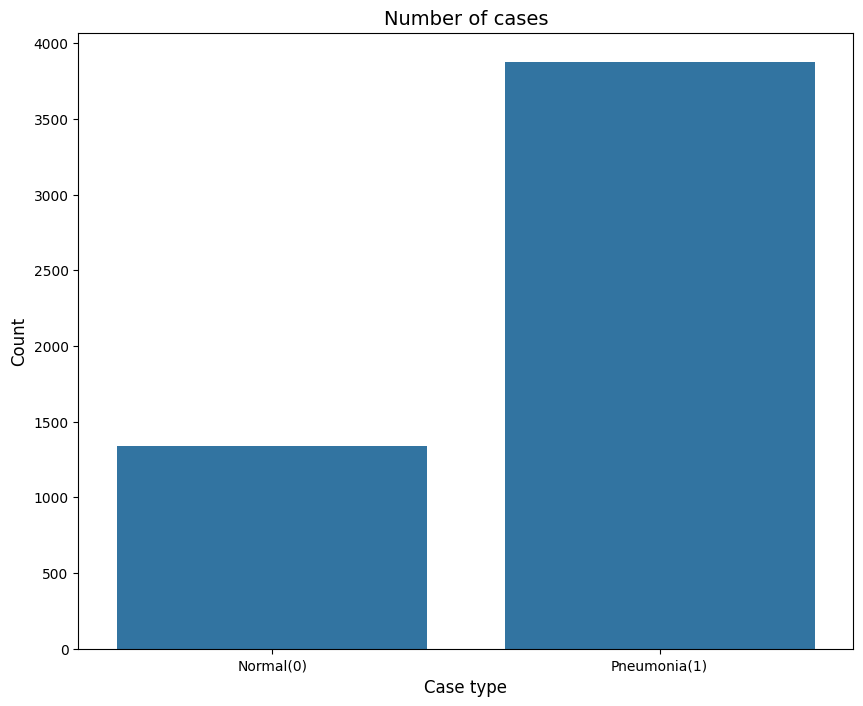

In [7]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

Let's take a look in a few images of each class.

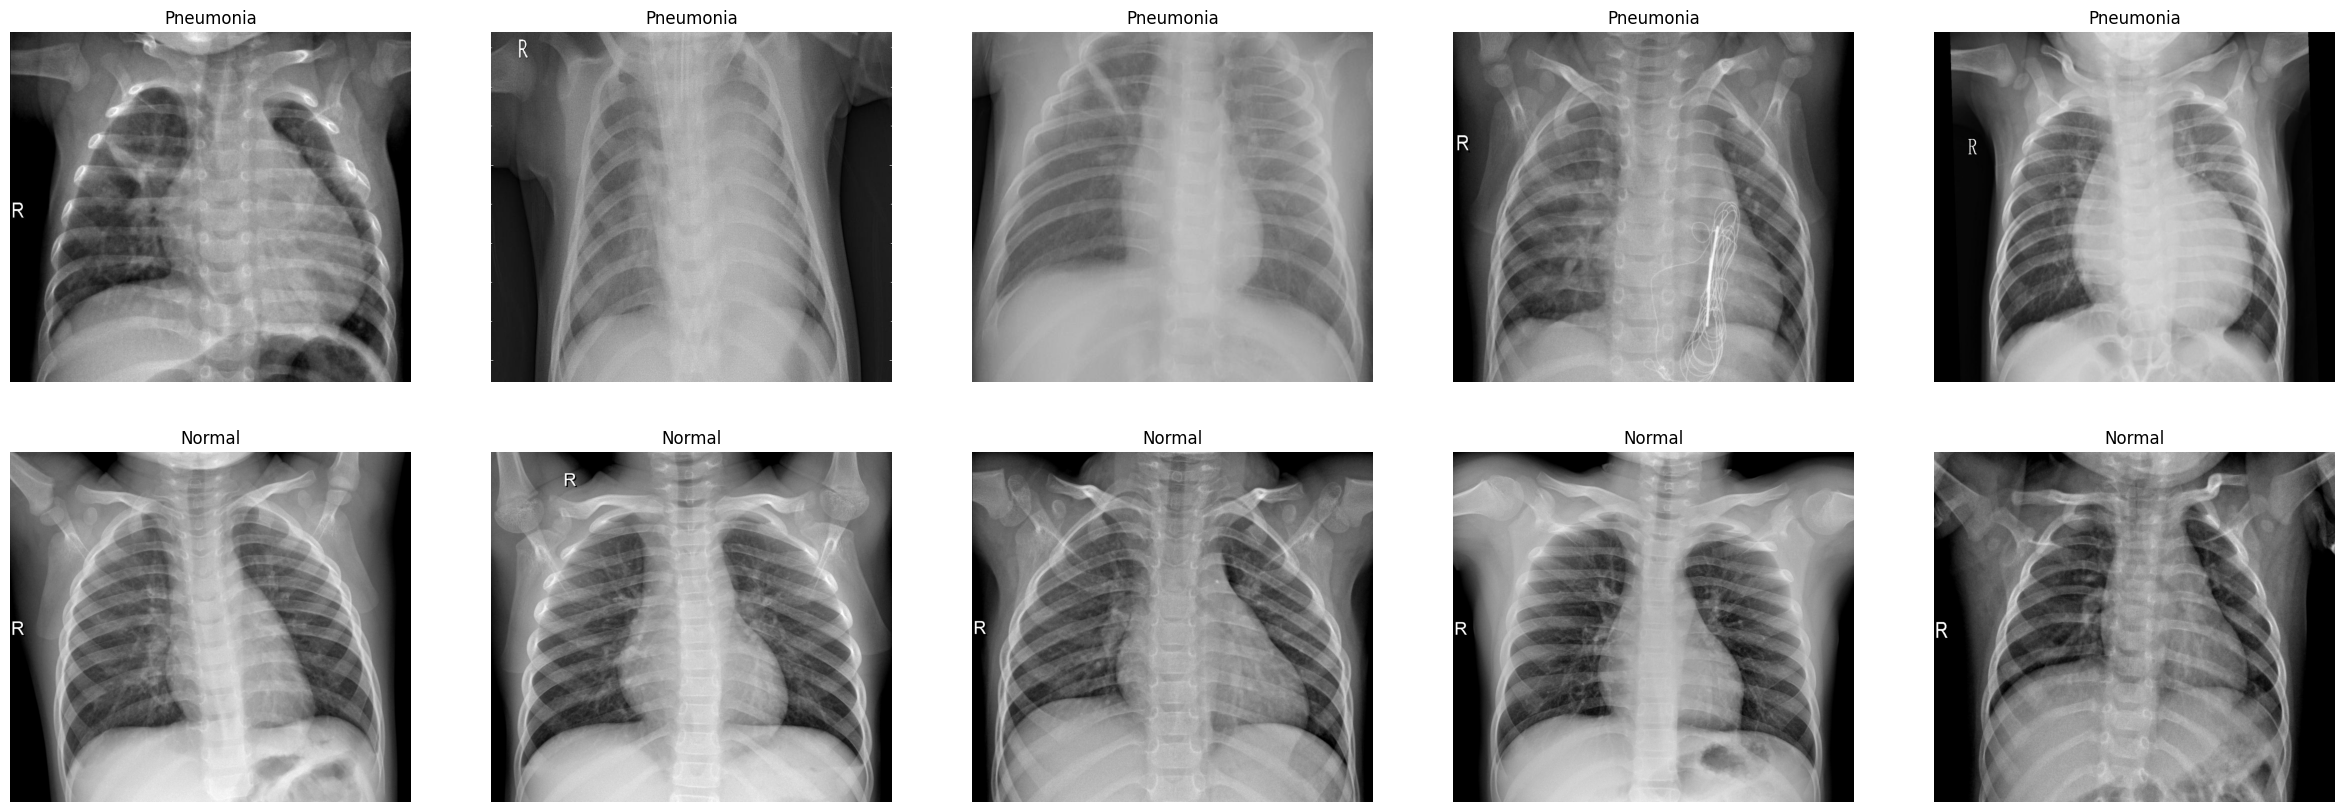

In [8]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Now let's build a generator to our training set, so we don't need do load all the data all in the same time.

We don't need to do that for the validation set because is a small set.

In [9]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

# Pneumonia cases
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


## Data Augmentation

Now we will generated dat using data augmentation technique.

This is a technique for sampling new data using the data in the unbalanced class. That's done applying feel changes to the old data.

This builds a more robust model.

In [23]:

# Augmentation sequence using Albumentations
augmentation = A.Compose([
    OneOf([
        HorizontalFlip(p=0.5),  # Horizontal flips
        Rotate(limit=20, p=0.5),  # Rotation
        RandomBrightnessContrast(brightness_limit=(0.2, 0.5), p=0.5)  # Random brightness
    ])
])

def preprocess_image(img_path, augment=False):
    """
    Preprocess a single image: load, augment (optional), and normalize.
    """
    # Convert PosixPath to string
    img_path = str(img_path)

    # Load and decode image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize and normalize
    image = tf.image.resize(image, (224, 224)) / 255.0

    if augment:
        # Use Albumentations for augmentation
        image = image.numpy()  # Convert to numpy for Albumentations
        image = augmentation(image=image)['image']
        image = tf.convert_to_tensor(image, dtype=tf.float32)

    return image

def data_gen(data, batch_size, augment=False):
    """
    Generator to yield batches of preprocessed images and labels.
    """
    n = len(data)  # Total samples
    indices = np.arange(n)  # Create indices
    while True:
        np.random.shuffle(indices)  # Shuffle data at each epoch
        for i in range(0, n, batch_size):
            batch_indices = indices[i:i+batch_size]  # Get batch indices
            batch_data = []
            batch_labels = []

            for idx in batch_indices:
                # Get image path and label
                img_path = data.iloc[idx]['image']
                label = data.iloc[idx]['label']

                # Preprocess the image
                image = preprocess_image(img_path, augment=augment)

                # One-hot encode the label
                encoded_label = to_categorical(label, num_classes=2)

                # Add to batch
                batch_data.append(image.numpy())
                batch_labels.append(encoded_label)

            # Convert to numpy arrays
            batch_data = np.array(batch_data, dtype=np.float32)
            batch_labels = np.array(batch_labels, dtype=np.float32)

            yield batch_data, batch_labels

## Modeling and Training:
Build models to solve the given problem.

- **Select the most suitable algorithms for the problem and the chosen dataset, justifying your choices.**  
  The chosen model was a CNN, which is ideal for image classification tasks.

- **Is there any initial adjustment to the hyperparameters?**  
  Due to the long training time, only a few hyperparameters were tested. The following values were used: epochs \{5, 20\} and batch_size \{32, 16\}, with the latter producing the best results.

- **Was the model properly trained? Was underfitting observed?**  
  Both in training and validation, the model showed good results with an increase in accuracy and a decrease in the loss function. This indicates that the model performed well during training. Unfortunately, the output from the training cell was lost, so detailed training information was not retained.

- **Is it possible to optimize the hyperparameters of the models? If so, do it and justify all choices.**  
  It is always possible to improve hyperparameter selection. Due to the long training time, a manual search was chosen. However, with better computational resources, techniques such as AutoML, Bayesian search, or Hyperband could have been used.

- **Are there any advanced or more complex methods that could be evaluated?**  
  Other models could be tested for comparison, such as EfficientNet, Vision Transformers, ResNet, DenseNet, or MobileNet.

- **Can I create an ensemble of different models for the problem?**  
  By utilizing other models like the ones mentioned above, it would be possible to create an ensemble for image classification. Due to the computational cost, the ensemble was not implemented.

## Model

Here we will build our model.

To do that let's build a convolution neural network(CNN) that is ideal for image classification.

In [11]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [12]:
model =  build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1_1 (Conv2D)                     │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1_2 (Conv2D)                     │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2_1 (Conv2D)                     │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2_2 (Conv2D)                     │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_1 (SeparableConv2D)            │ (None, 56, 56, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_2 (SeparableConv2D)            │ (None, 56, 56, 256)         │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_3 (SeparableConv2D)            │ (None, 56, 56, 256)         │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_1 (SeparableConv2D)            │ (None, 28, 28, 512)         │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_2 (SeparableConv2D)            │ (None, 28, 28, 512)         │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_3 (SeparableConv2D)            │ (None, 28, 28, 512)         │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 104,392,386 (398.23 MB)

 Trainable params: 104,389,314 (398.21 MB)

 Non-trainable params: 3,072 (12.00 KB)

To spare time we will apply another technique called transfer learning, downloading pretrained weights of another architecure.

But here we will apply transfer learning only on the first 4 conv layers of the model, using the pretrained VGG16 on imagenet.

Because the first layers are responsible for capturing edges, borders, ..., we using this weights in our model.

In [13]:
# Open the VGG16 weight file
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Função para carregar e atribuir pesos a uma camada específica
def load_weights(weights, model_layer_index):
    model.layers[model_layer_index].set_weights(weights)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
two_first_layers = [(1,'block1_conv1'),(2,'block1_conv2'),(4,'block2_conv1'), (5,'block2_conv2')]

for (i, model_layer_name) in two_first_layers:
    layer_weights = model.layers[i].get_weights()
    print(f"Layer {i} expects {len(layer_weights)} weight tensors.")
    weights = vgg16.get_layer(model_layer_name).get_weights()
    print(weights[0].shape)
    load_weights(weights, i)

model.summary()

Layer 1 expects 2 weight tensors.
(3, 3, 3, 64)
Layer 2 expects 2 weight tensors.
(3, 3, 64, 64)
Layer 4 expects 2 weight tensors.
(3, 3, 64, 128)
Layer 5 expects 2 weight tensors.
(3, 3, 128, 128)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1_1 (Conv2D)                     │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1_2 (Conv2D)                     │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2_1 (Conv2D)                     │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2_2 (Conv2D)                     │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_1 (SeparableConv2D)            │ (None, 56, 56, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_2 (SeparableConv2D)            │ (None, 56, 56, 256)         │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_3 (SeparableConv2D)            │ (None, 56, 56, 256)         │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_1 (SeparableConv2D)            │ (None, 28, 28, 512)         │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_2 (SeparableConv2D)            │ (None, 28, 28, 512)         │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 28, 28, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_3 (SeparableConv2D)            │ (None, 28, 28, 512)         │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 104,392,386 (398.23 MB)

 Trainable params: 104,389,314 (398.21 MB)

 Non-trainable params: 3,072 (12.00 KB)

Let's define the optimizer, learning_rate and the callback.

Here I've used 16 for batch_size and 20 for number of epochs

In [31]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(learning_rate=0.0001, weight_decay=1e-6)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath=weights_filepath, save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [17]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [18]:
# # Fit the model

def weighted_data_generator(generator, class_weights):
    for batch_data, batch_labels in generator:
        # Garantir que batch_labels tem o formato correto
        if len(batch_labels) != len(batch_data):
            raise ValueError("Mismatch between batch_data and batch_labels lengths.")

        # Calcular os sample_weights com base nas classes
        sample_weights = np.array([class_weights[np.argmax(label)] for label in batch_labels])

        # Retornar batch_data, batch_labels, e sample_weights
        yield batch_data, batch_labels, sample_weights

# Gerador com pesos
train_data_gen_weighted = weighted_data_generator(train_data_gen, {0: 1.0, 1: 0.4})

# # Treinamento do modelo
# history = model.fit(
#     train_data_gen_weighted,
#     epochs=nb_epochs,
#     steps_per_epoch=nb_train_steps,
#     validation_data=(valid_data, valid_labels),
#     callbacks=[es, chkpt],
#     verbose=1
# )

## Evaluation of Results:
Analyze the performance of the generated models on unseen data (using the test dataset).

- **Select evaluation metrics appropriate for the problem, justifying your choice.  
Train the chosen model on the entire training dataset and evaluate it on the test dataset.**  
  Accuracy and Recall were the primary metrics used to evaluate the model.

- **Do the results make sense?**  
  The recall is very high (0.99), indicating that the model almost always correctly identifies cases of Pneumonia. This is crucial in healthcare problems, where minimizing false negatives is important. The precision is lower (0.80), which suggests a relatively high rate of false positives (Normal classified as Pneumonia). This may lead to unnecessary additional tests for some patients. However, this is acceptable in many medical diagnostic scenarios, as erring on the side of "caution" (classifying Normal as Pneumonia) is generally less harmful than missing a case of Pneumonia.

- **Compare the results of different models.**  
  Since only one model was implemented, there is no comparison between different models.

- **Was any overfitting observed?**  
  There does not seem to be significant overfitting. The test dataset showed an accuracy of 0.838 and a loss of 0.674, suggesting that the model can generalize well to unseen data. If overfitting were present, we would expect to see a large difference between the performance on training/validation data and the test dataset (e.g., high accuracy on training but low accuracy on testing). This behavior was not observed here.

In [19]:
# Load the model weights
model.load_weights(os.path.join(directory, 'best_model_2_todate.weights.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)


test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [21]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.7002 - loss: 1.2504
Loss on test set:  0.6743457317352295
Accuracy on test set:  0.8381410241127014


In [22]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

39/39 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step
(624,)
(624,)


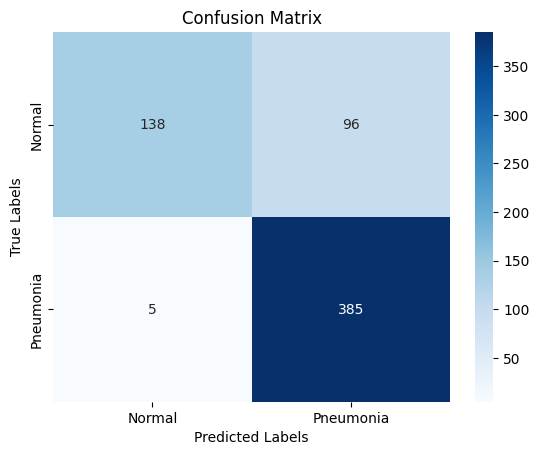

In [29]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
# Plotar a matriz de confusão
#plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.80


## Conclusion

The results of the pneumonia classification model indicate that it performs effectively in identifying cases of pneumonia, with a high recall of 0.99, ensuring that nearly all true cases are detected. This high recall is critical in medical diagnostics, as missing a case of pneumonia can have severe consequences. Although the precision is slightly lower at 0.80, leading to some false positives (Normal classified as Pneumonia), this trade-off is often acceptable in healthcare contexts where prioritizing sensitivity is more important than specificity. The model demonstrated good generalization to unseen data, with a test accuracy of 83.8% and a reasonable loss of 0.674, suggesting no significant overfitting. These results underline the model's potential utility in supporting medical professionals by providing reliable initial classifications that can aid in early diagnosis and treatment decisions. However, further refinements, such as ensemble methods or adjustments to the decision threshold, could be explored to improve precision without compromising recall.